Run on NERSC

In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits

from scipy.optimize import root_scalar

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
from scipy.optimize import curve_fit

def get_frac_moffat(r, alpha, beta):
    """
    Calculate the fraction of light within radius r of a Moffat profile.
    """    
    frac = 1 - alpha**(2*(beta-1))*(alpha**2 + r**2)**(1-beta)
    return(frac)

def get_sb_moffat(r, alpha, beta):
    """
    Calculate the surface brightness of light at radius r of a Moffat profile.
    The integral (i.e., total flux) is unity by definition.
    """
    i = (beta-1)/(np.pi * alpha**2)*(1 + (r/alpha)**2)**(-beta)
    return i

def get_sb_moffat_plus_power_law(r, alpha1, beta1, plexp2, weight2):
    """
    Calculate the surface brightness of light at radius r of the sum of two Moffat profiles.
    The integral (i.e., total flux) is NOT unity.
    """
    i = (beta1-1)/(np.pi * alpha1**2)*(1 + (r/alpha1)**2)**(-beta1) \
        + weight2 *r**(plexp2)
    return i

def get_sb_double_moffat(r, alpha1, beta1, alpha2, beta2, weight2):
    """
    Calculate the surface brightness of light at radius r of the sum of two Moffat profiles.
    The integral (i.e., total flux) is NOT unity.
    """
    i = (beta1-1)/(np.pi * alpha1**2)*(1 + (r/alpha1)**2)**(-beta1) \
        + weight2 * (beta2-1)/(np.pi * alpha2**2)*(1 + (r/alpha2)**2)**(-beta2)
    return i

In [4]:
params = {
'g_weight2': 0.00045, 'g_plexp2': -2.,
'r_weight2': 0.00033, 'r_plexp2': -2.,
'z_alpha2': 17.650, 'z_beta2': 1.7, 'z_weight2': 0.0145,
}

outlier_ccd_list = ['N20', 'S8', 'S10', 'S18', 'S21', 'S27']
params_outlier = {'z_alpha2': 16, 'z_beta2': 2.3, 'z_weight2': 0.0095}

field = 'south'
region_name = 'decals_ngc'
pixscale = 0.262

In [5]:
# Medians of the Moffat parameters
moffat_medians = {'g_alpha': 0.86, 'g_beta': 2.48, 'r_alpha': 0.67, 'r_beta': 2.23, 'z_alpha': 0.51, 'z_beta': 2.00}

# DECam - GAIA range
g_2sigma_min, g_2sigma_max, g_3sigma_min, g_3sigma_max =  0.22, 1.91, -0.12, 2.28
r_2sigma_min, r_2sigma_max, r_3sigma_min, r_3sigma_max =  -0.17, 0.41, -0.30, 0.67
z_2sigma_min, z_2sigma_max, z_3sigma_min, z_3sigma_max =  -1.57, -0.10, -1.86, 0.31

keys = ['g_2sigma_min', 'g_2sigma_max', 'r_2sigma_min', 'r_2sigma_max', 'z_2sigma_min', 'z_2sigma_max', 'g_3sigma_min', 'g_3sigma_max', 'r_3sigma_min', 'r_3sigma_max', 'z_3sigma_min', 'z_3sigma_max']
values = [g_2sigma_min, g_2sigma_max, r_2sigma_min, r_2sigma_max, z_2sigma_min, z_2sigma_max, g_3sigma_min, g_3sigma_max, r_3sigma_min, r_3sigma_max, z_3sigma_min, z_3sigma_max]
decam_gaia_ranges = {keys[i]: values[i] for i in range(len(keys))}

## Plot the radius-magnitude relation (which is the inverse of the PSF profiles)
## overplot the DR9 radius -magnitude relation

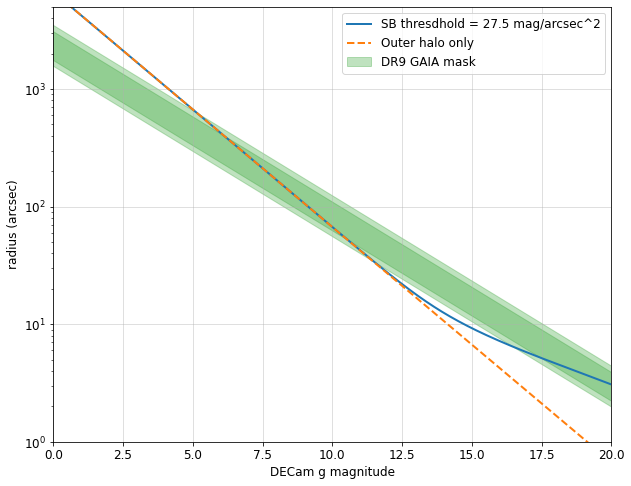

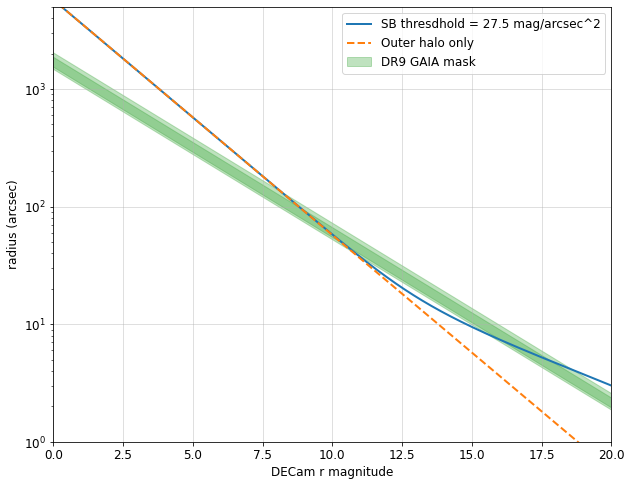

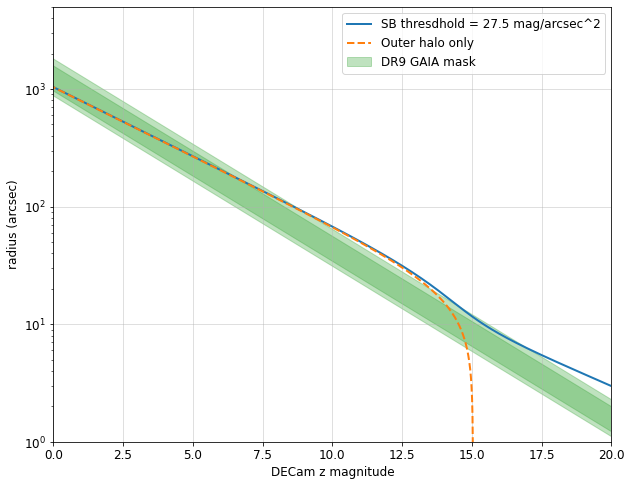

In [9]:
for band in ['g', 'r', 'z']:

    alpha, beta = moffat_medians[band+'_alpha'], moffat_medians[band+'_beta']

    radius = np.logspace(-1, np.log10(10000), 1000)

    sb_limit_in_mag = 27.5
    sb_limit_in_nmgy = 10**((22.5-sb_limit_in_mag)/2.5)

    # nanomaggies per sq arcsec:
    if band!='z':
        plexp2, weight2 = params[band+'_plexp2'], params[band+'_weight2']
        flux_all = get_sb_moffat_plus_power_law(radius, alpha, beta, plexp2, weight2)
        flux_inner = get_sb_moffat(radius, alpha, beta)
        flux_outer = weight2 * radius**(plexp2)
    else:
        alpha2, beta2, weight2 = params[band+'_alpha2'], params[band+'_beta2'],  params[band+'_weight2']
        flux_all = get_sb_double_moffat(radius, alpha, beta, alpha2, beta2, weight2)
        flux_inner = get_sb_moffat(radius, alpha, beta)
        flux_outer = weight2 * get_sb_moffat(radius, alpha2, beta2)

    mag_at_radius = 22.5+2.5*np.log10(flux_all/sb_limit_in_nmgy)
    mag_at_radius_outer = 22.5+2.5*np.log10(flux_outer/sb_limit_in_nmgy)

    # compare with DR9 GAIA mask
    gaia_radius_2sigma_min = 1630 * 1.396**(-(mag_at_radius-decam_gaia_ranges[band+'_2sigma_min']))
    gaia_radius_2sigma_max = 1630 * 1.396**(-(mag_at_radius-decam_gaia_ranges[band+'_2sigma_max']))
    gaia_radius_3sigma_min = 1630 * 1.396**(-(mag_at_radius-decam_gaia_ranges[band+'_3sigma_min']))
    gaia_radius_3sigma_max = 1630 * 1.396**(-(mag_at_radius-decam_gaia_ranges[band+'_3sigma_max']))
    
    plt.figure(figsize=(10, 8))
    plt.semilogy(mag_at_radius, radius, '-', lw=2, label='SB thresdhold = {:.1f} mag/arcsec^2'.format(sb_limit_in_mag))
    plt.semilogy(mag_at_radius_outer, radius, '--', lw=2, label='Outer halo only', color='C1')
    plt.fill_between(mag_at_radius, gaia_radius_2sigma_min, gaia_radius_2sigma_max, alpha=0.3, label='DR9 GAIA mask', color='C2')
    plt.fill_between(mag_at_radius, gaia_radius_3sigma_min, gaia_radius_3sigma_max, alpha=0.3, color='C2')
    plt.grid(alpha=0.5)
    # plt.title(' ')
    plt.xlabel('DECam {} magnitude'.format(band))
    plt.ylabel('radius (arcsec)')
    # plt.axhline(5., lw=2, ls='--', color='k')
    plt.axis([0, 20, 1, 5000])
    plt.legend()
    plt.show()

---------
## SB threshold as 1% of the LS fidicual sky brightness

In [7]:
fidicual_sb_limit_in_mag = {'g':27.04, 'r':25.91, 'z':23.46}

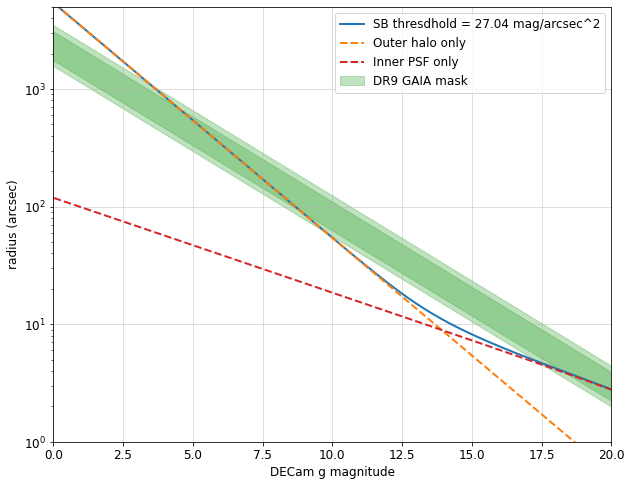

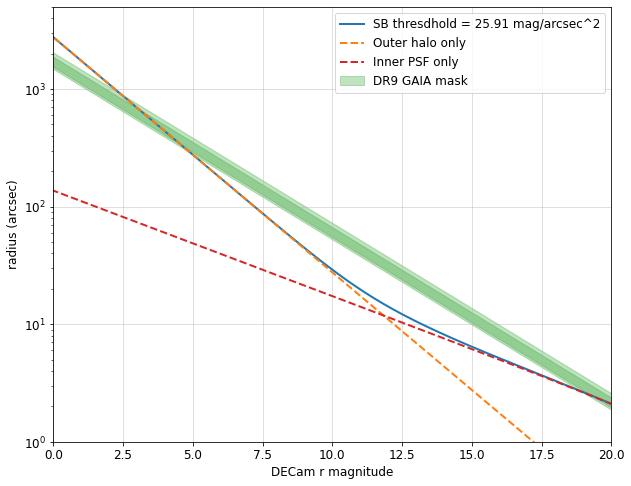

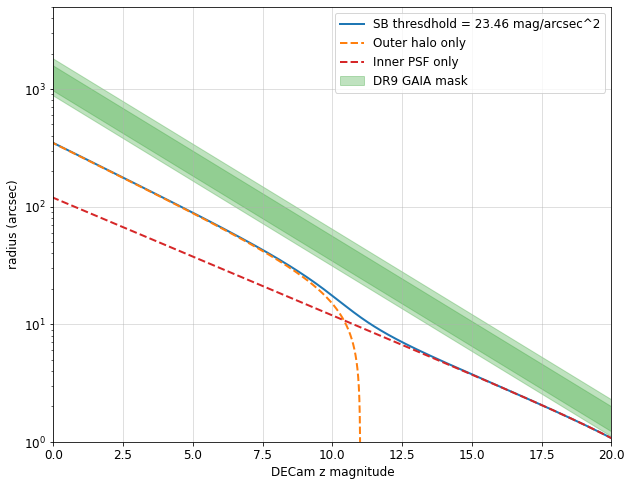

In [8]:
for band in ['g', 'r', 'z']:

    alpha, beta = moffat_medians[band+'_alpha'], moffat_medians[band+'_beta']

    radius = np.logspace(-1, np.log10(10000), 1000)

    sb_limit_in_mag = fidicual_sb_limit_in_mag[band]
    sb_limit_in_nmgy = 10**((22.5-sb_limit_in_mag)/2.5)

    # nanomaggies per sq arcsec:
    if band!='z':
        plexp2, weight2 = params[band+'_plexp2'], params[band+'_weight2']
        flux_all = get_sb_moffat_plus_power_law(radius, alpha, beta, plexp2, weight2)
        flux_inner = get_sb_moffat(radius, alpha, beta)
        flux_outer = weight2 * radius**(plexp2)
    else:
        alpha2, beta2, weight2 = params[band+'_alpha2'], params[band+'_beta2'],  params[band+'_weight2']
        flux_all = get_sb_double_moffat(radius, alpha, beta, alpha2, beta2, weight2)
        flux_inner = get_sb_moffat(radius, alpha, beta)
        flux_outer = weight2 * get_sb_moffat(radius, alpha2, beta2)

    mag_at_radius = 22.5+2.5*np.log10(flux_all/sb_limit_in_nmgy)
    mag_at_radius_outer = 22.5+2.5*np.log10(flux_outer/sb_limit_in_nmgy)
    mag_at_radius_inner = 22.5+2.5*np.log10(flux_inner/sb_limit_in_nmgy)

    # compare with DR9 GAIA mask
    gaia_radius_2sigma_min = 1630 * 1.396**(-(mag_at_radius-decam_gaia_ranges[band+'_2sigma_min']))
    gaia_radius_2sigma_max = 1630 * 1.396**(-(mag_at_radius-decam_gaia_ranges[band+'_2sigma_max']))
    gaia_radius_3sigma_min = 1630 * 1.396**(-(mag_at_radius-decam_gaia_ranges[band+'_3sigma_min']))
    gaia_radius_3sigma_max = 1630 * 1.396**(-(mag_at_radius-decam_gaia_ranges[band+'_3sigma_max']))
    
    plt.figure(figsize=(10, 8))
    plt.semilogy(mag_at_radius, radius, '-', lw=2, label='SB thresdhold = {:g} mag/arcsec^2'.format(sb_limit_in_mag))
    plt.semilogy(mag_at_radius_outer, radius, '--', lw=2, label='Outer halo only', color='C1')
    plt.semilogy(mag_at_radius_inner, radius, '--', lw=2, label='Inner PSF only', color='C3')
    plt.fill_between(mag_at_radius, gaia_radius_2sigma_min, gaia_radius_2sigma_max, alpha=0.3, label='DR9 GAIA mask', color='C2')
    plt.fill_between(mag_at_radius, gaia_radius_3sigma_min, gaia_radius_3sigma_max, alpha=0.3, color='C2')
    plt.grid(alpha=0.5)
    # plt.title(' ')
    plt.xlabel('DECam {} magnitude'.format(band))
    plt.ylabel('radius (arcsec)')
    # plt.axhline(5., lw=2, ls='--', color='k')
    plt.axis([0, 20, 1, 5000])
    plt.legend()
    plt.show()